## 北京地铁线路图绘制

In [517]:
import json 
import re
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [518]:
#读取北京地铁信息json文件，为字典
with open("subway.json",'r', encoding='UTF-8') as f:
     load_dict = json.load(f)

In [519]:
#从字典中，获取站点名、及对应的经纬坐标
def get_s_location_1():
    s_location_1 = {}
    for i in range(len(load_dict['l'])):
        for j in range(len(load_dict['l'][i]['st'])):
            s_name = load_dict['l'][i]['st'][j]['n']
            s_xy = load_dict['l'][i]['st'][j]['sl']
#            s_line = load_dict['l'][i]['ln']
            s_xy = re.findall('(\d+.\d+),(\d+.\d+)',s_xy)[0]
            s_xy = tuple(map(float,s_xy))
#            print(s_xy)
            s_location_1[s_name] = s_xy
#            s_location_2[s_name] = s_line

    return s_location_1


In [520]:
s_n_xy = get_s_location_1()

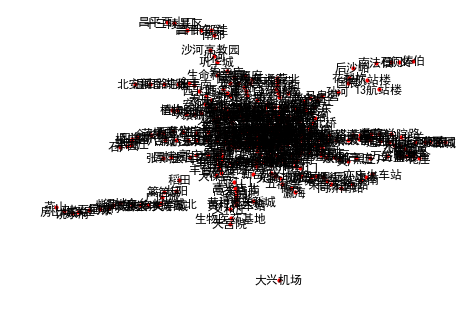

In [521]:
#按经纬绘制站点图

plt.rcParams['font.sans-serif'] = ['SimHei']#中文显示
s_graph = nx.Graph()
s_graph.add_nodes_from(list(s_location.keys()))

nx.draw(s_graph, s_location, with_labels=True, node_size=10)

## 站点连接绘制 

In [522]:
#获取站线号及其包括的站点名
def get_s_location_2():
    s_location_2 = []
    for i in range(len(load_dict['l'])):
        for j in range(len(load_dict['l'][i]['st'])):
            s_name = load_dict['l'][i]['st'][j]['n']
#            s_xy = load_dict['l'][i]['st'][j]['sl']
            s_line = load_dict['l'][i]['ln']
#            s_xy = re.findall('(\d+.\d+),(\d+.\d+)',s_xy)[0]
#            s_xy = tuple(map(float,s_xy))
#            print(s_xy)
#            s_location_1[s_name] = s_xy
            s = []
            s[:1]=[s_name,s_line]
            s_location_2.append(s)#列表嵌套列表，防止字典去重的影响
#            s_location_2.append({s_name:s_line})#站点名和站点所在线组成键值对，加入列表，防止直接形成字典后去重的影响。

    return s_location_2

In [523]:
s_n_l = get_s_location_2()

In [524]:
#双向连接相邻站点

def build_connection(s_n_l):
    stations_connection = defaultdict(list)
    for i in range(len(s_n_l)):
#        for j in range(i+1,len(s_n_l)):
            if i+1 >= len(s_n_l): break
            if s_n_l[i][1] == s_n_l[i+1][1]:
                stations_connection[s_n_l[i][0]].append(s_n_l[i+1][0])
                stations_connection[s_n_l[i+1][0]].append(s_n_l[i][0])  #双向连接

    return stations_connection



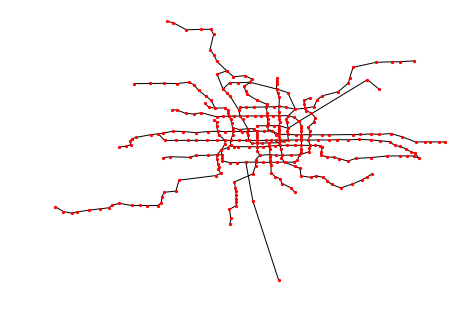

In [526]:
#绘制连接好的地铁图

stations_connection = build_connection(s_n_l)
stations_connection_graph = nx.Graph(stations_connection)
nx.draw(stations_connection_graph,s_location,with_labels=False,node_size=5)


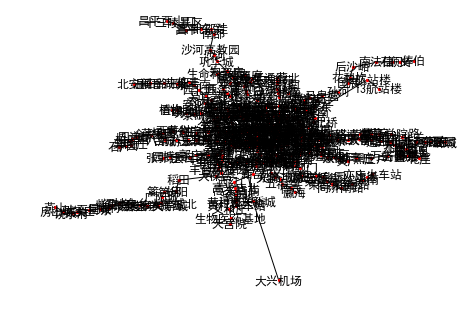

In [527]:
nx.draw(stations_connection_graph,s_location,with_labels=True,node_size=5)

## 选择路径
### BFS

In [528]:
#搜寻两站点路径

def search(graph,start,destination):
    pathes = [[start]]  # list 用来存储待搜索路径
    visited = set() # set用来存储已搜索的节点
    
    while pathes:
        path = pathes.pop(0)  #提取第一条路径
        froniter = path[-1]   #提取即将要探索的节点
        
        if froniter in visited: continue  #检查如果该点已经探索过 则不用再探索
            
        successsors = graph[froniter]
        
        for city in successsors:      #遍历子节点
            if city in path: continue  # check loop #检查会不会形成环
            
            new_path = path+[city]
            
            pathes.append(new_path)  #bfs     #将新路径加到list里面
            #pathes = [new_path] + pathes #dfs
            
            if city == destination:  #检查目的地是不是已经搜索到了
                return new_path
        visited.add(froniter)

## 路线输出（包括站点及对应线号）

In [529]:
#获取某地铁站所属的所有线号

def get_line_number(lis,name):
    line_number = []
    snl_out = list(filter(lambda x: name == x[0], lis))
    for i in range(len(snl_out)): #该站所有线路号
        line_number.append(snl_out[i][1])
    
    return line_number


In [530]:
#获得目标路径中，站点的所属线路号

def get_line_num_all():
    line_num_all = []
    line_numbers = []
    
    for i in range(len(p)):
        line_numbers.append(get_line_number(s_n_l,p[i]))#获得要搜索的路径中，i地铁站所属的所有线路号
    
    for i in range(len(line_numbers)):
        if i+1 >=len(line_numbers): break
        line_num_all += (x for x in line_numbers[i] if x in line_numbers[i+1] )
    line_num_all += (y for y in line_numbers[-1] if y in line_numbers[-2])
    return line_num_all

In [531]:
#获取站名与线号
def get_final_n_l(start,destination):
    final_n_l = []
    p = search(stations_connection,start,destination)
    num = get_line_num_all()
    final_n_l_ = [[a,b] for a,b in zip(p,num)]
    for i in range(len(p)):
        one = ' / '.join(final_n_l_[i])
        final_n_l.append(one)
    
    return ' ---> '.join(final_n_l)

In [532]:
get_final_n_l('巴沟','西直门')

'巴沟 / 10号线 ---> 苏州街 / 10号线 ---> 海淀黄庄 / 10号线 ---> 知春里 / 10号线 ---> 知春路 / 13号线 ---> 大钟寺 / 13号线 ---> 西直门 / 13号线'